In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
plt.style.use('ggplot')
#pd.set_option('max_rows',200) 
pd.set_option('display.float_format', '{:.4f}'.format) # Set decimals 


# Plot choices
sns.set(style="whitegrid")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
cars = pd.read_csv('cars.csv')
labs = pd.read_csv('labels_values.csv')
dict_varnames = pd.read_csv('labels_variables.csv').set_index('variable').to_dict()['label']

# to translate market indices to names of countries 
labs.index += 1 
dict_ma = labs.market.dropna().to_dict()


cars['country'] = cars['ma'].map(dict_ma)

# Recalculate 'qu_total' with correct country mapping STYR PÅ DEN HER

cars['qu_total'] = cars.groupby(['ma','ye'])['qu'].transform('sum')
#cars['qu_total'] = cars.groupby(['country', 'ye'])['qu'].transform('sum')

# Calculate 's' with the newly defined 'qu_total'
cars['s'] = cars['qu'] / cars['qu_total']

# Data cleaning - replacing commas and converting to float
columns_to_clean = ['hp', 'li', 'li1', 'li2', 'li3', 'ngdp', 'rgdp', 'princ', 'pr', 'tax', 'avdexr', 'ac', 'le', 'sp']
for column in columns_to_clean:
    if column in cars.columns:
        cars[column] = cars[column].str.replace(',', '.').astype(float)

cars['log_s'] = np.log(cars['s']) #/(0.5)

dict_cla = labs.classs.dropna().to_dict()
cars['class'] = cars['cla'].map(dict_cla)




- Få styr på cars['qu_total']

In [3]:
# Optional: Log transformation of 's' if it helps with analysis or modeling
# cars['log_s'] = np.log(cars['s'])

# Set the figure size for the scatterplot
#plt.figure(figsize=(10, 6))
#sns.scatterplot(data=cars, x='hp', y='s', hue='country', style='class', alpha=0.6)
#plt.title('Market Share vs. Horsepower by Country and Class')
#plt.xlabel('Horsepower (hp)')
#plt.ylabel('Market Share (s)')
#plt.legend(title='Country/Class', bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.tight_layout()
#plt.show()

In [4]:
# Tjek de nye værdier af 's'
print(cars['s'].describe())

cars['s']

count   11549.0000
mean        0.0130
std         0.0209
min         0.0001
25%         0.0017
50%         0.0053
75%         0.0149
max         0.2712
Name: s, dtype: float64


0       0.0024
1       0.0056
2       0.0052
3       0.0058
4       0.0057
         ...  
11544   0.0020
11545   0.0043
11546   0.0092
11547   0.0025
11548   0.0041
Name: s, Length: 11549, dtype: float64

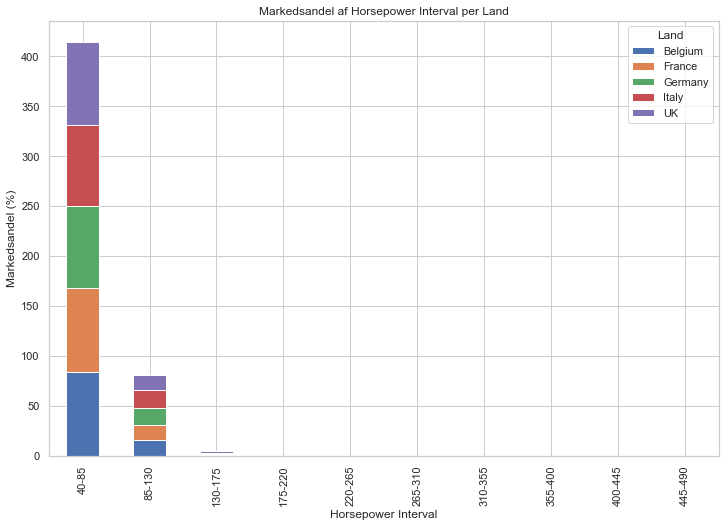

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Eksempel data
# Antag at 'cars' er dit DataFrame og allerede indeholder kolonnerne 'hp' (hestekræfter) og 'country' (land)
# cars = pd.read_csv('din_fil.csv')

# Tilføj en ny kolonne for at kategorisere hestekræfter i intervaller
bins = range(40, 500, 45)  # Juster intervallerne efter behov fra 40 til 500 med skridt på 45
cars['hp_bin'] = pd.cut(cars['hp'], bins=bins, labels=[f'{i}-{i+45}' for i in bins[:-1]])

# Beregn markedsandel indenfor hver hp interval og per land
hp_market_shares = cars.groupby(['country', 'hp_bin']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).reset_index(name='market_share')

# Pivoter data for bedre visualisering
hp_market_shares_pivot = hp_market_shares.pivot(index='hp_bin', columns='country', values='market_share')

# Plot data som stakket søjlediagram
hp_market_shares_pivot.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Markedsandel af Horsepower Interval per Land')
plt.xlabel('Horsepower Interval')
plt.ylabel('Markedsandel (%)')
plt.legend(title='Land')
plt.show()


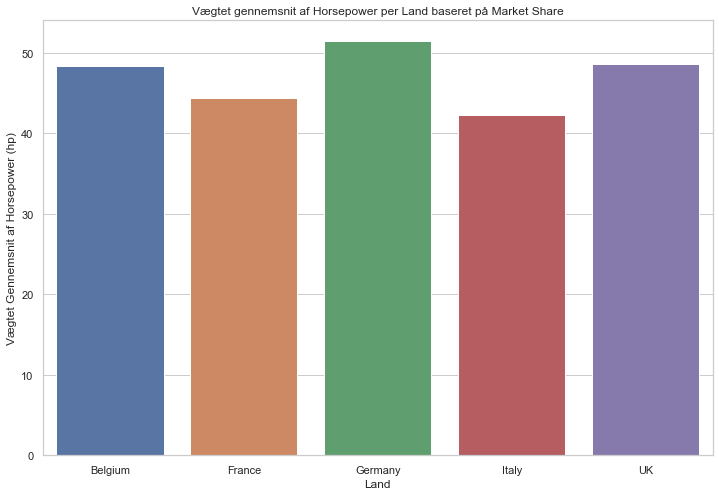

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Antag at 'cars' er dit DataFrame og allerede indeholder alle nødvendige kolonner og korrekte datatyper
# Beregn det vægtede gennemsnit af 'hp' (hestekræfter) for hver 'country' baseret på markedsandelen 's' som vægte
weighted_avg_hp = cars.groupby('country').apply(lambda x: np.average(x['hp'], weights=x['s'])).reset_index(name='weighted_hp')

# Visualisering af det vægtede gennemsnit af hestekræfter for hvert land
plt.figure(figsize=(12, 8))
sns.barplot(x='country', y='weighted_hp', data=weighted_avg_hp)
plt.title('Vægtet gennemsnit af Horsepower per Land baseret på Market Share')
plt.xlabel('Land')
plt.ylabel('Vægtet Gennemsnit af Horsepower (hp)')
plt.show()


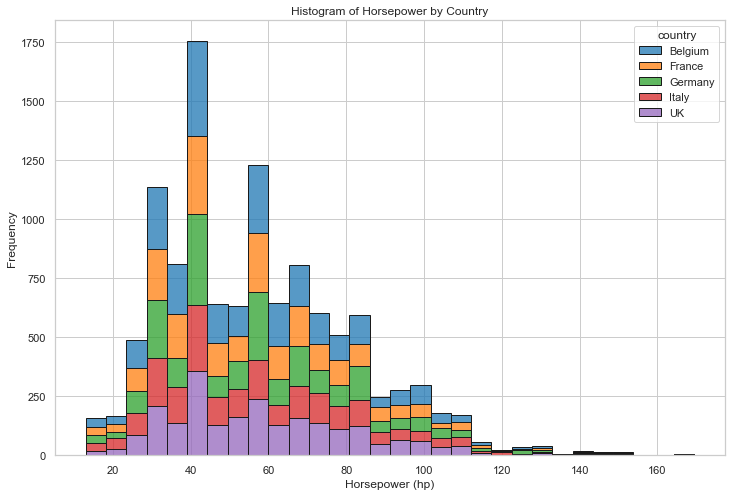

In [7]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Create a combined histogram with the 'hue' parameter to differentiate by country
sns.histplot(data=cars, x='hp', hue='country', multiple='stack', bins=30, palette='tab10', edgecolor='k')

# Set titles and labels
plt.title('Histogram of Horsepower by Country')
plt.xlabel('Horsepower (hp)')
plt.ylabel('Frequency')

# Show the plot
plt.show()


* Hvor mange der er - 40-45 og aggregere deres salg - fås automatisk ved indbyggede funktioner med mikro data
    * Hvor mange obs af biler for et givet interval
    * Jeg får hvor

- Fordeling af horsepower i hvert land, 
- Alle biler folk ejer, mere retvisende billede
- Market_shares for horsepowers så man kan se det
- princs, we, le, ...
- Summe market_shares indenfor hvert interval

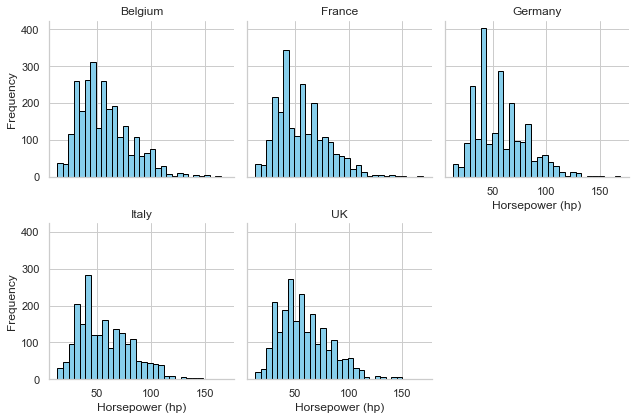

In [8]:
# Set up the FacetGrid with seaborn
g = sns.FacetGrid(cars, col='country', col_wrap=3, sharex=True, sharey=True)

# Map the histograms to the FacetGrid
g.map(plt.hist, 'hp', bins=30, color='skyblue', edgecolor='black')

# Add titles and labels
g.set_titles('{col_name}')
g.set_axis_labels('Horsepower (hp)', 'Frequency')

# Adjust the layout so that titles and labels don't overlap
g.tight_layout()

# Show the plot
plt.show()


# Average market share for each horsepower category per country

<Figure size 1008x504 with 0 Axes>

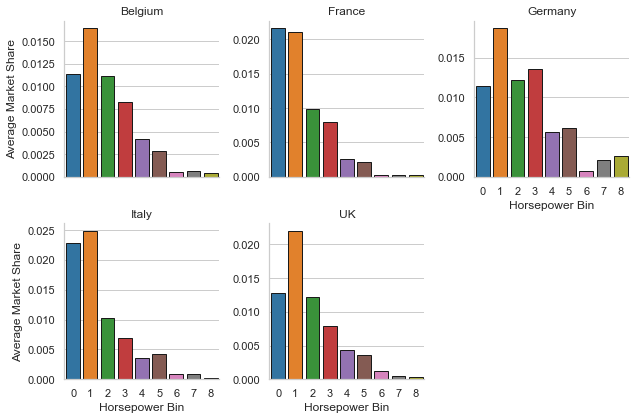

In [9]:
# Define the number of bins for horsepower
bins = np.linspace(cars['hp'].min(), cars['hp'].max(), num=10)

# Assign each car to a horsepower bin
cars['hp_bin'] = pd.cut(cars['hp'], bins, labels=np.arange(len(bins)-1))

# Group by country and horsepower bin, then calculate the average market share
avg_market_share = cars.groupby(['country', 'hp_bin'])['s'].mean().reset_index()

# Now plot the average market share for each country and horsepower bin as a bar plot
plt.figure(figsize=(14, 7))

# Because there are multiple countries and horsepower bins, we may choose to facet by country
# to make the plot clearer
g = sns.FacetGrid(avg_market_share, col='country', col_wrap=3, sharey=False)
g.map_dataframe(sns.barplot, x='hp_bin', y='s', palette='tab10', edgecolor='k')
g.set_axis_labels('Horsepower Bin', 'Average Market Share')
g.set_titles(col_template='{col_name}')

plt.show()


**ER DET 'ma' eller 'country'** - Generelt for andre figurer også

Forholde sig mere til figurerne:
- Tyskland kører på flest hestekrafter, mens frankrig og italien kører på dem med lavest. 

# Step 1: Creating a Histogram for Horsepower Distribution

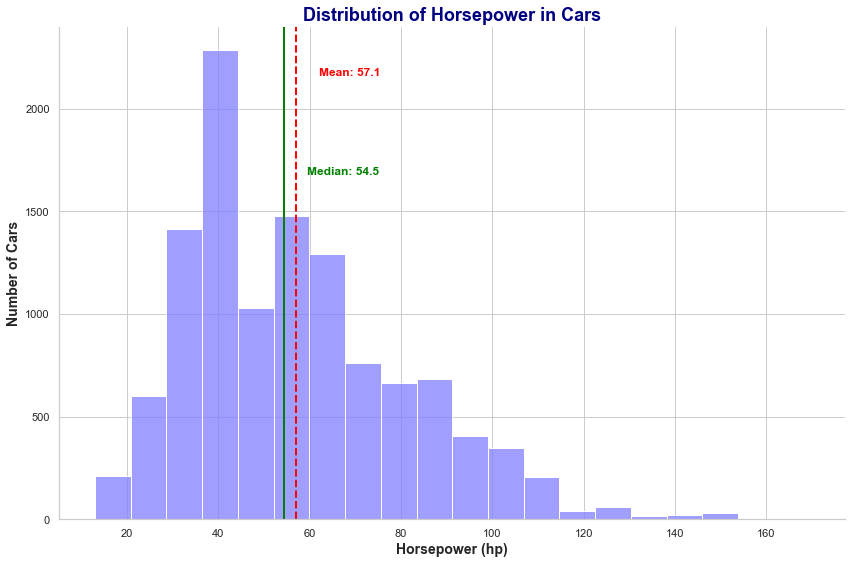

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `cars['hp']` is available in your environment
hp_data = cars['hp']  # replace with actual horsepower data

plt.figure(figsize=(12, 8))

# Use seaborn's style
sns.set_style('whitegrid')

# Use a seaborn color palette and edgecolor for a modern look
sns.histplot(hp_data, bins=20, kde=False, color=sns.color_palette('cool', n_colors=1)[0], edgecolor='white')

# Plot mean and median lines
mean_val = hp_data.mean()
median_val = hp_data.median()
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2)
plt.axvline(median_val, color='green', linestyle='-', linewidth=2)

# Add annotations for mean and median
plt.text(mean_val + 5, plt.ylim()[1] * 0.9, f'Mean: {mean_val:.1f}', color='red', fontweight='bold')
plt.text(median_val + 5, plt.ylim()[1] * 0.7, f'Median: {median_val:.1f}', color='green', fontweight='bold')

# Set title and labels with enhanced styling
plt.title('Distribution of Horsepower in Cars', fontsize=18, fontweight='bold', color='navy')
plt.xlabel('Horsepower (hp)', fontsize=14, fontweight='bold')
plt.ylabel('Number of Cars', fontsize=14, fontweight='bold')

# Remove the top and right spines for a cleaner look
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()


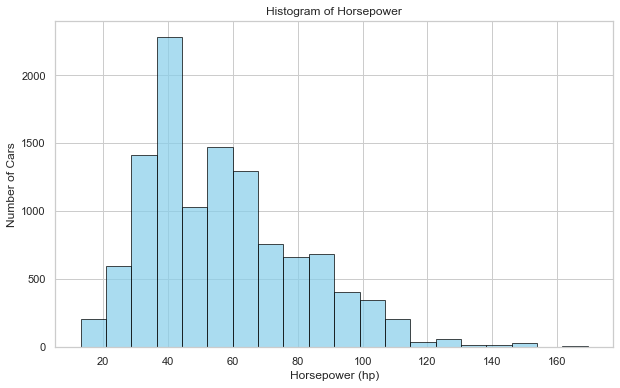

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(cars['hp'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Horsepower')
plt.xlabel('Horsepower (hp)')
plt.ylabel('Number of Cars')
plt.show()

Lave figur note her
- Hvad ser vi på figuren
    - Number of cars?
    - Forklare hvordan det er lavet
    - Aggregere forskellige models for horsepower
    - Selvfoklarende tabel
    - Færre bins (bins=20)

# Step 2: Creating a Binned Scatter Plot for Average Horsepower


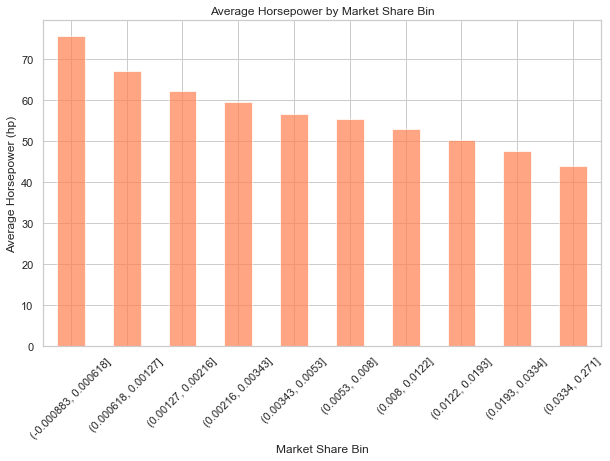

In [12]:
# Bin the market share data
cars['market_share_bin'] = pd.qcut(cars['s'], q=10, duplicates='drop')  # Creating 10 quantile-based bins

# Calculate the average horsepower for each bin
avg_hp_per_bin = cars.groupby('market_share_bin')['hp'].mean()

# Plotting
plt.figure(figsize=(10, 6))
avg_hp_per_bin.plot(kind='bar', color='coral', alpha=0.7)
plt.title('Average Horsepower by Market Share Bin')
plt.xlabel('Market Share Bin')
plt.ylabel('Average Horsepower (hp)')
plt.xticks(rotation=45)
plt.show()


- Summe her også
- Binn scatter
    - x og y, laver bins, gennemsnittet for hvert bin
    - Summe marketshares på x aksen og horsepower på yaksen

# Calculating Average Horsepower by Year


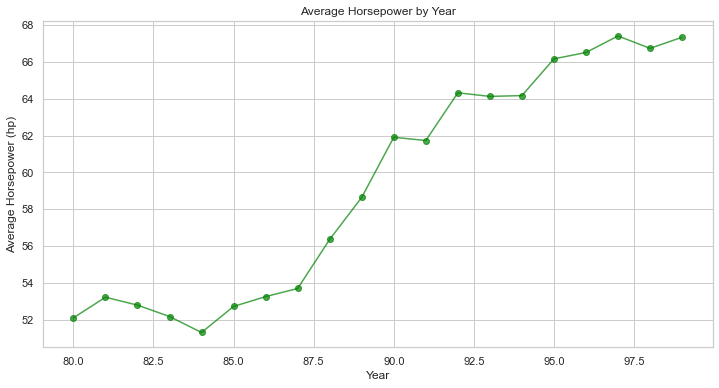

In [13]:
# Filtrer data til kun at inkludere år fra 1980 til 2000
filtered_cars = cars[(cars['ye'] >= 80) & (cars['ye'] <= 100)]

# Grupper efter år og beregn gennemsnitlig hestekraft
avg_hp_per_year = filtered_cars.groupby('ye')['hp'].mean()

# Plotting af gennemsnitlig hestekraft over årene
plt.figure(figsize=(12, 6))
avg_hp_per_year.plot(kind='line', marker='o', color='green', alpha=0.7)
plt.title('Average Horsepower by Year')
plt.xlabel('Year')
plt.ylabel('Average Horsepower (hp)')
plt.grid(True)
plt.show()


- Average over forskellige alle brands
- Lave et vægtet gennemsnit så det er for lamboginier og toyotaer for sig kan man sige
- Alt vægtes med marketshares
- Manuelt regne ud evt. 

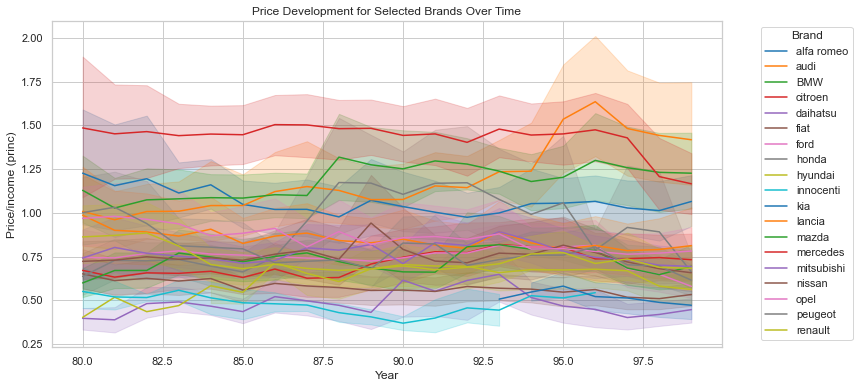

In [14]:
# Correctly handle infinite and missing values before any manipulation
cars.replace([np.inf, -np.inf], np.nan, inplace=True)

# Filter the dataset for selected brands and the year range 1980 to 2000
selected_brands = cars[
    (cars['brand'].isin(['alfa romeo', 'audi', 'BMW', 'citroen', 'daihatsu', 'fiat', 
                         'ford', 'honda', 'hyundai', 'innocenti', 'kia', 'lancia', 'mazda', 'mercedes',
                         'mitsubishi', 'nissan', 'opel', 'peugeot', 'renault'])) & 
    (cars['ye'] >= 80) & (cars['ye'] <= 100)
]

# Create a line plot showing the development of prices over years for the selected brands
plt.figure(figsize=(12, 6))
sns.lineplot(data=selected_brands, x='ye', y='princ', hue='brand', palette='tab10')  # Adjusted for a better color palette
plt.title('Price Development for Selected Brands Over Time')
plt.xlabel('Year')
plt.ylabel('Price/income (princ)')
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position

# Show the plot
plt.show()


- Kigge på mercedes - måske fjerne for den ene obs.
- Se om der er taget gennemsnit - mere præcis 
- sns - rigtige library?
- Begrunde spiken - evt. noget valuta - 

- BMW har stor (95% af markedet) og lille (5%)
    - Den store har højere price income ratio
        - Og price
    - De tæller ikke lige meget
    - Tage 5% gange price/income lille + 95%*price/income stor
    - Skaber en market share rate
    - (Vægtet gennemsnit)
- Være mere selektiv hvis det er
    - For 5-10 største brands
        - Mindre støj
- Price/income og price ratio
    - Graf for hver

# Plotting Price Development for All Brands Over Time

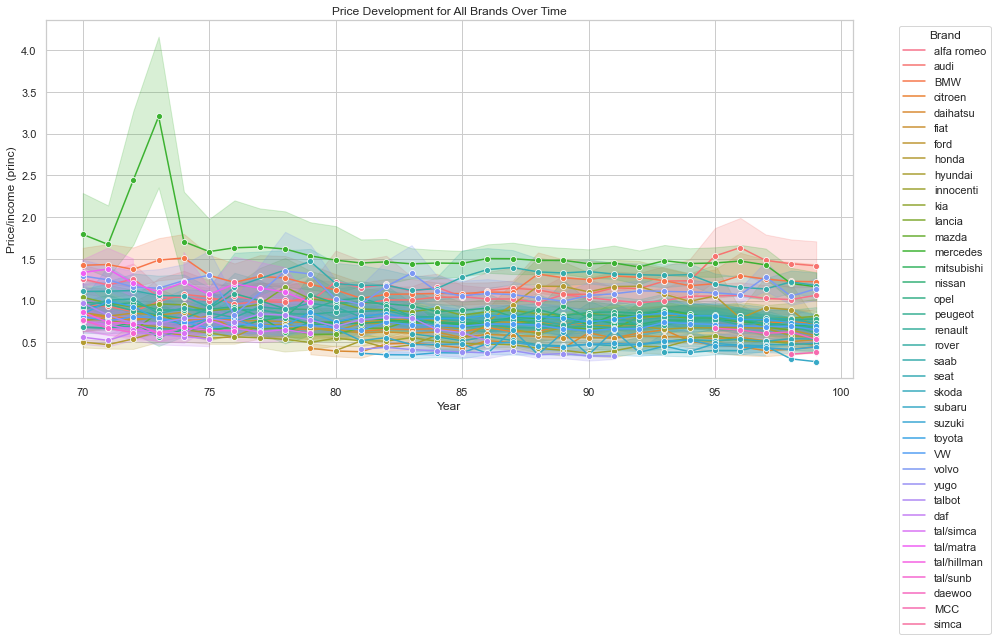

In [15]:
# Create a line plot showing the development of prices over years for all brands
# Filter the dataset for the year range 1980 to 2000 for all brands
filtered_cars_all_brands = cars[(cars['ye'] >= 80) & (cars['ye'] <= 100)]
plt.figure(figsize=(14, 8))
sns.lineplot(data=cars, x='ye', y='princ', hue='brand', marker='o', legend='full')
plt.title('Price Development for All Brands Over Time')
plt.xlabel('Year')
plt.ylabel('Price/income (princ)')
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.tight_layout()


- lave nogle grafer for at se hvad der er i variablerne - variable over tid
- Giver det mening at tage pris/indkomst (lokal valuta) på tværs af lande (med inflation) - læse verbovens paper mm. for hvilke mål
- Enheden i prices
- Faste og løbende priser - inflation => rene priser= fjerne inflation samt
- Giver det mening med priser for brands

# Using regplot for a Single Scatterplot with Regression Line


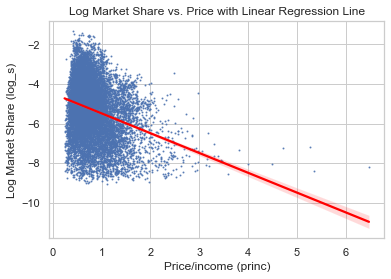

In [16]:
# Use seaborn's regplot to create a scatterplot of 'pr' vs. 'log_s'.
# 'x' specifies the data for the x-axis (Price in this case).
# 'y' specifies the data for the y-axis (Log Market Share in this case).

sns.regplot(x='princ', y='log_s', data=cars, scatter_kws={'s': 1}, line_kws={'color': 'red'})

# Set the title of the plot with plt.title.
plt.title('Log Market Share vs. Price with Linear Regression Line')

# Set the label for the x-axis with plt.xlabel.
plt.xlabel('Price/income (princ)')

# Set the label for the y-axis with plt.ylabel.
plt.ylabel('Log Market Share (log_s)')

# Display the plot with plt.show().
plt.show()


# Integrate this into the regression setup - Only with prices

In [17]:
#### Replace 'pr', 'hp' etc., with the actual attribute names you want to include
cars['princ'] = pd.to_numeric(cars['princ'], errors='coerce')
# Convert additional attributes as needed

# Replace any infinite values with NaN and then drop rows with NaN values in these columns
cars.replace([np.inf, -np.inf], np.nan, inplace=True)
cars.dropna(subset=['princ'], inplace=True)  #

# Prepare your independent variables DataFrame including the constant and other variables
X = cars[['princ']]  # I can add more attributes if it is needed
X = sm.add_constant(X)

# Define your dependent variable
y = cars['log_s']

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print the summary of your regression model
print(model.summary())

print(cars.shape)


                            OLS Regression Results                            
Dep. Variable:                  log_s   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     937.2
Date:                Mon, 29 Apr 2024   Prob (F-statistic):          5.85e-198
Time:                        08:13:25   Log-Likelihood:                -20599.
No. Observations:               11549   AIC:                         4.120e+04
Df Residuals:                   11547   BIC:                         4.122e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.4855      0.030   -148.674      0.0

# Integrate this into the regression setup

In [18]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Liste over attributter
attributes = ['princ', 'we', 'ac', 'hp', 'le']

# Sørg for, at alle relevante kolonner er renset for NaN og uendelige værdier
cars[attributes] = cars[attributes].replace([np.inf, -np.inf], np.nan)
cars.dropna(subset=attributes, inplace=True)

# Loop gennem hver attribut og kør regression kun med 'princ' og den pågældende attribut
for attr in attributes:
    if attr != 'princ':  # Undgå dobbelt optælling af 'princ'
        X_attr = sm.add_constant(cars[[attr, 'princ']])  # Tilføj kun 'princ' og den aktuelle attribut
        model_attr = sm.OLS(cars['log_s'], X_attr).fit()
        print(f"Regression med pris og {attr}:")
        print(model_attr.summary())
        print("\n")
    else:  # Hvis attributen er 'princ', inkluder kun 'princ'
        X_price = sm.add_constant(cars[['princ']])
        model_price = sm.OLS(cars['log_s'], X_price).fit()
        print("Regression kun med pris:")
        print(model_price.summary())
        print("\n")

# Til sidst kør en regression med alle attributter inkluderet
X_all = sm.add_constant(cars[attributes])
model_all = sm.OLS(cars['log_s'], X_all).fit()
print("Regression med alle attributter:")
print(model_all.summary())


Regression kun med pris:
                            OLS Regression Results                            
Dep. Variable:                  log_s   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     783.2
Date:                Mon, 29 Apr 2024   Prob (F-statistic):          1.70e-165
Time:                        08:13:25   Log-Likelihood:                -16539.
No. Observations:                9232   AIC:                         3.308e+04
Df Residuals:                    9230   BIC:                         3.310e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.3815      

In [19]:
countries = ['Belgium', 'France', 'Germany', 'Italy', 'UK']

attributes = ['we', 'ac', 'hp', 'le']  # 'princ' udelades, da det er den afhængige variabel

# Relevante kolonner er renset for NaN og uendelige værdier
cars[attributes + ['princ']] = cars[attributes + ['princ']].replace([np.inf, -np.inf], np.nan)
cars.dropna(subset=attributes + ['princ'], inplace=True)

# Gemme resultater
country_attribute_effects = {}

# Loop igennem hvert land og attribut for at køre separate regressioner
for country in countries:
    print(f"------ {country} ------")
    country_attribute_effects[country] = {}
    cars_country = cars[cars['country'] == country]  # Filtrer data for det specifikke land

    for attr in attributes:
        # Tilføj en konstant til modellen for at fange intercept
        X = sm.add_constant(cars_country[[attr]])  # Inkluder kun den pågældende attribut

        # 'princ' er den afhængige variabel
        y = cars_country['princ']

        # Tilpas multivariat lineær regressionsmodel
        model = sm.OLS(y, X).fit()

        # Gem koefficienten for attributten
        country_attribute_effects[country][attr] = model.params[attr]
    
    # Print modelsummary for landet
    print(f"Effekter for {country}:")
    for attr, effect in country_attribute_effects[country].items():
        print(f"Effekt af {attr}: {effect:.4f}")
    print("\n")


------ Belgium ------
Effekter for Belgium:
Effekt af we: 0.0013
Effekt af ac: -0.0347
Effekt af hp: 0.0125
Effekt af le: 0.0058


------ France ------
Effekter for France:
Effekt af we: 0.0012
Effekt af ac: -0.0333
Effekt af hp: 0.0125
Effekt af le: 0.0056


------ Germany ------
Effekter for Germany:
Effekt af we: 0.0011
Effekt af ac: -0.0286
Effekt af hp: 0.0103
Effekt af le: 0.0049


------ Italy ------
Effekter for Italy:
Effekt af we: 0.0016
Effekt af ac: -0.0391
Effekt af hp: 0.0151
Effekt af le: 0.0073


------ UK ------
Effekter for UK:
Effekt af we: 0.0017
Effekt af ac: -0.0447
Effekt af hp: 0.0160
Effekt af le: 0.0081




- Køre regressionerne country by country => se om princ ryger på minus
- Det er horsepower som påvirker princ - den går fra negativ til positiv, hvilket ikke burde være rigtigt
- Lave om på estimater
- Understreger endogenitetsproblemet => princ

- **Spørgsmål**:
    - ac har en positiv effekt og ikke hp??

# Forklarende variabler og model-dummies i OLS-regression

In [20]:
# Tjekker for at sikre, at 'brand' kolonnen eksisterer
print(cars.columns)

# Hvis 'brand' eksisterer, opretter vi dummy-variabler
if 'brand' in cars.columns:
    cars = pd.get_dummies(cars, columns=['brand'], drop_first=True)
else:
    print("'brand' kolonnen findes ikke i DataFrame.")


Index(['ye', 'ma', 'co', 'zcode', 'brd', 'type', 'brand', 'model', 'org',
       'loc', 'cla', 'home', 'frm', 'qu', 'cy', 'hp', 'we', 'pl', 'do', 'le',
       'wi', 'he', 'li1', 'li2', 'li3', 'li', 'sp', 'ac', 'pr', 'princ',
       'eurpr', 'exppr', 'avexr', 'avdexr', 'avcpr', 'avppr', 'avdcpr',
       'avdppr', 'xexr', 'tax', 'pop', 'ngdp', 'rgdp', 'engdp', 'ergdp',
       'engdpc', 'ergdpc', 'country', 'qu_total', 's', 'log_s', 'class',
       'hp_bin', 'market_share_bin'],
      dtype='object')


In [21]:
# Antag at 'pr' er prisen, og 'hp' er hestekræfter
X = cars[['princ', 'hp']]  # Starter med prisen og hestekræfter
X = pd.concat([X, cars.filter(regex='brand_')], axis=1)  # Tilføjer brand-dummy-variablerne
X = sm.add_constant(X)  # Tilføjer en konstant til modellen - estimere den basale værdi af den afhængige variabel, når alle de uafhængige variabler er nul. 
#Det forbedrer modeltilpasningen og sikrer mere nøjagtige og realistiske estimater.

y = cars['log_s']  # Logaritmiske markedsandel

# Kører OLS-modellen
model = sm.OLS(y, X).fit()

# Viser summary af modellen
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  log_s   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     132.9
Date:                Mon, 29 Apr 2024   Prob (F-statistic):               0.00
Time:                        08:13:25   Log-Likelihood:                -14894.
No. Observations:                9232   AIC:                         2.987e+04
Df Residuals:                    9193   BIC:                         3.014e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.7786      0.08

# IV-regression

## Beregne summen af hp for hver biltype, hvert år, og hvert land

In [22]:
print(cars.columns)

Index(['ye', 'ma', 'co', 'zcode', 'brd', 'type', 'model', 'org', 'loc', 'cla',
       'home', 'frm', 'qu', 'cy', 'hp', 'we', 'pl', 'do', 'le', 'wi', 'he',
       'li1', 'li2', 'li3', 'li', 'sp', 'ac', 'pr', 'princ', 'eurpr', 'exppr',
       'avexr', 'avdexr', 'avcpr', 'avppr', 'avdcpr', 'avdppr', 'xexr', 'tax',
       'pop', 'ngdp', 'rgdp', 'engdp', 'ergdp', 'engdpc', 'ergdpc', 'country',
       'qu_total', 's', 'log_s', 'class', 'hp_bin', 'market_share_bin',
       'brand_MCC', 'brand_VW', 'brand_alfa romeo', 'brand_audi',
       'brand_citroen', 'brand_daewoo', 'brand_daf', 'brand_daihatsu',
       'brand_fiat', 'brand_ford', 'brand_honda', 'brand_hyundai',
       'brand_innocenti', 'brand_kia', 'brand_lancia', 'brand_mazda',
       'brand_mercedes', 'brand_mitsubishi', 'brand_nissan', 'brand_opel',
       'brand_peugeot', 'brand_renault', 'brand_rover', 'brand_saab',
       'brand_seat', 'brand_simca', 'brand_skoda', 'brand_subaru',
       'brand_suzuki', 'brand_tal/hillman', 'brand

In [26]:
import numpy as np
import pandas as pd

alpha = -1.0026 #Pris-koefficient fra OLS regressionen 

# Erstatning af 0 i markedsandelen med NaN for at undgå division med nul i beregningen
cars['own_price_elasticity'] = alpha * cars['princ'] / (1 - cars['s'].replace(0, np.nan))

# Liste af kolonner for forskellige brands
brand_columns = [
    'brand_MCC', 'brand_VW', 'brand_alfa romeo', 'brand_audi',
    'brand_citroen', 'brand_daewoo', 'brand_daf', 'brand_daihatsu',
    'brand_fiat', 'brand_ford', 'brand_honda', 'brand_hyundai',
    'brand_innocenti', 'brand_kia', 'brand_lancia', 'brand_mazda',
    'brand_mercedes', 'brand_mitsubishi', 'brand_nissan', 'brand_opel',
    'brand_peugeot', 'brand_renault', 'brand_rover', 'brand_saab',
    'brand_seat', 'brand_simca', 'brand_skoda', 'brand_subaru',
    'brand_suzuki', 'brand_tal/hillman', 'brand_tal/simca',
    'brand_tal/sunb', 'brand_talbot', 'brand_toyota', 'brand_volvo',
    'brand_yugo'
]

# Dictionary til at holde gennemsnitlig priselasticitet og samlet markedsandel for hvert brand
brand_data = {}

# Beregning af gennemsnitlig priselasticitet for hvert brand
for brand_col in brand_columns:
    brand_cars = cars[cars[brand_col] == 1]
    
    if not brand_cars.empty:
        # Beregn den vægtede sum af elasticiteter for brandet
        weighted_sum = np.sum(brand_cars['own_price_elasticity'] * brand_cars['s'])
        # Beregn den samlede sum af markedsandele for brandet
        total_market_share = np.sum(brand_cars['s'])
        # Beregn det vægtede gennemsnit af elasticitet for brandet
        average_elasticity = weighted_sum / total_market_share if total_market_share != 0 else np.nan
        brand_data[brand_col] = (average_elasticity, total_market_share)
    else:
        brand_data[brand_col] = (np.nan, 0)

# Print resultatet
for brand, data in brand_data.items():
    print(f"{brand} - Elasticity: {data[0]:.4f}, Market Share: {data[1]:.4f}")


brand_MCC - Elasticity: -0.3802, Market Share: 0.0218
brand_VW - Elasticity: -0.6369, Market Share: 14.1011
brand_alfa romeo - Elasticity: -0.9565, Market Share: 1.4810
brand_audi - Elasticity: -0.9132, Market Share: 4.4967
brand_citroen - Elasticity: -0.6615, Market Share: 7.0223
brand_daewoo - Elasticity: -0.5690, Market Share: 0.1974
brand_daf - Elasticity: -0.5516, Market Share: 0.2958
brand_daihatsu - Elasticity: -0.4483, Market Share: 0.1028
brand_fiat - Elasticity: -0.7042, Market Share: 17.1760
brand_ford - Elasticity: -0.7539, Market Share: 17.3370
brand_honda - Elasticity: -0.7440, Market Share: 0.8978
brand_hyundai - Elasticity: -0.5410, Market Share: 0.2200
brand_innocenti - Elasticity: -0.6666, Market Share: 0.2715
brand_kia - Elasticity: -0.4685, Market Share: 0.0516
brand_lancia - Elasticity: -0.8828, Market Share: 2.6259
brand_mazda - Elasticity: -0.6388, Market Share: 1.1792
brand_mercedes - Elasticity: -1.2860, Market Share: 4.5217
brand_mitsubishi - Elasticity: -0.66

In [27]:

# Gem det eksisterende datasæt under et andet navn før du genererer nye data
existing_cars = cars.copy()

# Genererer simulerede data for biler
np.random.seed(0)
simulated_cars = pd.DataFrame({
    'brand': np.random.choice(['brand_MCC', 'brand_VW', 'brand_alfa romeo', 'brand_audi',
                               'brand_citroen', 'brand_daewoo', 'brand_daf', 'brand_daihatsu',
                               'brand_fiat', 'brand_ford', 'brand_honda', 'brand_hyundai',
                               'brand_innocenti', 'brand_kia', 'brand_lancia', 'brand_mazda',
                               'brand_mercedes', 'brand_mitsubishi', 'brand_nissan', 'brand_opel',
                               'brand_peugeot', 'brand_renault', 'brand_rover', 'brand_saab',
                               'brand_seat', 'brand_simca', 'brand_skoda', 'brand_subaru',
                               'brand_suzuki', 'brand_tal/hillman', 'brand_tal/simca',
                               'brand_tal/sunb', 'brand_talbot', 'brand_toyota', 'brand_volvo', 'brand_yugo'], size=1000),
    'ye': np.random.choice(range(1980, 1998), size=1000),
    'country': np.random.choice(['Belgium', 'France', 'Germany', 'Italy', 'UK'], size=1000),
    'hp': np.random.randint(0, 1000000, size=1000)
})


In [28]:
# Gruppering efter brand, år, og land i den simulerede data
grouped = simulated_cars.groupby(['brand', 'ye', 'country'])

# Beregner summen af hestekræfter for hver gruppe
hp_summ = grouped['hp'].sum().reset_index(name='hp_summ')

# Tæller antallet af biler i hver gruppe
car_count = grouped['hp'].count().reset_index(name='count')

# Tilføj denne information tilbage til den simulerede dataframe
simulated_cars = pd.merge(simulated_cars, hp_summ, on=['brand', 'ye', 'country'])
simulated_cars = pd.merge(simulated_cars, car_count, on=['brand', 'ye', 'country'])

# Justerer 'hp_sum' ved at trække bilens egen 'hp' fra den totale 'hp_sum'
simulated_cars['hp_adjusted_summ'] = simulated_cars['hp_summ'] - simulated_cars['hp']

# Print resultater for at undersøge problemet
print(simulated_cars[['brand', 'ye', 'country', 'hp', 'hp_summ', 'count', 'hp_adjusted_summ']])

                 brand    ye  country      hp  hp_summ  count  \
0            brand_MCC  1984  Belgium  410215   410215      1   
1           brand_audi  1987   France  810633   810633      1   
2           brand_audi  1990       UK  189464   487526      2   
3           brand_audi  1990       UK  298062   487526      2   
4           brand_ford  1990       UK  251972   251972      1   
..                 ...   ...      ...     ...      ...    ...   
995  brand_tal/hillman  1984  Germany  679903   679903      1   
996         brand_audi  1984  Germany  775385   775385      1   
997  brand_tal/hillman  1988       UK   22238    22238      1   
998       brand_subaru  1989    Italy  842059   842059      1   
999         brand_audi  1994    Italy  428746   428746      1   

     hp_adjusted_summ  
0                   0  
1                   0  
2              298062  
3              189464  
4                   0  
..                ...  
995                 0  
996                 0  
997

Trække fra det vi kiggede på

Trække det vi kigger på fra summen

## Implementering af første trin i IV-estimeringen:

In [29]:
# Gruppere data efter 'type', 'ye', og 'country' og beregne summen af 'hp', 'we', 'ac' og 'le' for hver gruppe
hp_sum = cars.groupby(['type', 'ye', 'country'])['hp'].sum().reset_index(name='hp_sum')

we_sum = cars.groupby(['type', 'ye', 'country'])['we'].sum().reset_index(name='we_sum')

ac_sum = cars.groupby(['type', 'ye', 'country'])['ac'].sum().reset_index(name='ac_sum')

le_sum = cars.groupby(['type', 'ye', 'country'])['le'].sum().reset_index(name='le_sum')

print(we_sum.head())

print(hp_sum.head())

print(le_sum.head())

print(ac_sum.head())


                      type  ye  country  we_sum
0  BMW 1500-1600-1602-1802  72  Belgium     930
1  BMW 1500-1600-1602-1802  72   France     930
2  BMW 1500-1600-1602-1802  72  Germany     930
3  BMW 1500-1600-1602-1802  72    Italy     930
4  BMW 1500-1600-1602-1802  72       UK     930
                      type  ye  country  hp_sum
0  BMW 1500-1600-1602-1802  72  Belgium 62.5000
1  BMW 1500-1600-1602-1802  72   France 62.5000
2  BMW 1500-1600-1602-1802  72  Germany 62.5000
3  BMW 1500-1600-1602-1802  72    Italy 70.5000
4  BMW 1500-1600-1602-1802  72       UK 62.5000
                      type  ye  country   le_sum
0  BMW 1500-1600-1602-1802  72  Belgium 423.0000
1  BMW 1500-1600-1602-1802  72   France 423.0000
2  BMW 1500-1600-1602-1802  72  Germany 423.0000
3  BMW 1500-1600-1602-1802  72    Italy 423.0000
4  BMW 1500-1600-1602-1802  72       UK 423.0000
                      type  ye  country  ac_sum
0  BMW 1500-1600-1602-1802  72  Belgium 13.3000
1  BMW 1500-1600-1602-1802  72   F

# Instrumenter for 'hp', 'ac', 'le', 'we'

In [30]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS

# Liste over attributter
attributes = ['hp', 'ac', 'we', 'le']

for attr in attributes:
    # Beregn summen af den pågældende attribut som et potentiale instrument
    
    # Log_s mod s and p => herfra estimere med IV, herunder have instrumenter (BLP beskriver summen)
    # summen af attributes 
    
    attr_sum = cars.groupby(['type', 'ye', 'country'])[attr].sum().reset_index(name=f'{attr}_sum')
    cars_IV = pd.merge(cars, attr_sum, on=['type', 'ye', 'country'])

    # Brug summen som instrument for 'princ'
    cars_IV['z'] = cars_IV[f'{attr}_sum']

    # Implementation af: p = \gamma*x1 + \phi*z + v, som er ('princ ~ x1 + z') => Første trins regression med 'z' som instrument for 'princ' 
    first_stage = smf.ols(f'princ ~ hp + ac + we + le + z', data=cars_IV).fit()
    #Princ = eneste afhængige variable, alle de andre er uafhængige
    
    # princ_fittet => forudsagte værdier
    cars_IV['princ_fitted'] = first_stage.fittedvalues  # Første trins forudsagte værdier

    if 'Intercept' not in cars_IV.columns:
        cars_IV['Intercept'] = 1.0
    
    # Vælg de eksogene variabler uden det aktuelle attribut
    exog_vars = ['Intercept'] + [x for x in ['hp', 'ac', 'we', 'le'] if x != attr]
    
    # Andet trins regression: Bruger IV2SLS
    second_stage = IV2SLS(dependent=cars_IV['log_s'], # Den afhængige variabel
                          exog=cars_IV[exog_vars], # Eksogene variabler
                          endog=cars_IV['princ_fitted'], # Den oprindelige1 endogene variabel
                          instruments=cars_IV['z']).fit() # 'z' er instrumentet
    # Her defineres ln(q) = \beta*x1 + \alpha*p + \epsilon
        # Forudsige 'princ' via instrumenter 
    print(f"First Stage Regression Summary using {attr} as the instrument:")
    print(first_stage.summary())
    print("\n")

    
    # Opsumering af IV2SLS => Finde effekt af 'princ' på 'log_s' via princ_fitted
    print(f"Second Stage IV Regression Summary using {attr} as the instrument:")
    print(second_stage.summary)
    print("\n")
    

    # Denne model bruger ikke de forudsagte værdier som de endogene variabler, men snarere de observerede værdier direkte sammen med de andre kontroller. 
    # Modellen giver en summarisk statistik, der ligner en normal regressionsanalyse uden IV-korrektion.

    # Opsumering af OLS => Sammenligne OLS-regressionen med IV-estimatoren
    # Bruges til at vurdere effekten af at korrigere for endogenitet
    second_stage_OLS = smf.ols('log_s ~ hp + ac + we + le + princ', data=cars_IV).fit(cov_type='HC3')
    print("OLS Regression for Comparison (without IV correction):")
    print(second_stage_OLS.summary())
    print("\n")

First Stage Regression Summary using hp as the instrument:
                            OLS Regression Results                            
Dep. Variable:                  princ   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     3994.
Date:                Mon, 29 Apr 2024   Prob (F-statistic):               0.00
Time:                        09:42:09   Log-Likelihood:                -324.77
No. Observations:                9232   AIC:                             659.5
Df Residuals:                    9227   BIC:                             695.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

First Stage Regression Summary using we as the instrument:
                            OLS Regression Results                            
Dep. Variable:                  princ   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     3994.
Date:                Mon, 29 Apr 2024   Prob (F-statistic):               0.00
Time:                        09:42:10   Log-Likelihood:                -324.77
No. Observations:                9232   AIC:                             659.5
Df Residuals:                    9227   BIC:                             695.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

Svage instrumenter kan føre til biased og ineffektive estiamter (Paper for Gandi instrumenter)

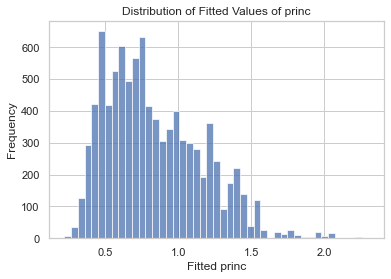

Summary stats for 'princ_fitted':
count   9232.0000
mean       0.8337
std        0.3298
min        0.2195
25%        0.5727
50%        0.7652
75%        1.0600
max        2.3047
Name: princ_fitted, dtype: float64
Summary stats for original 'princ':
count   9232.0000
mean       0.8337
std        0.4143
min        0.2418
25%        0.5405
50%        0.7386
75%        1.0189
max        6.4729
Name: princ, dtype: float64


In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

cars_IV['princ_fitted'] = first_stage.fittedvalues 

# Tjekker forudsagte værdier af 'princ'
sns.histplot(cars_IV['princ_fitted'])
plt.title('Distribution of Fitted Values of princ')
plt.xlabel('Fitted princ')
plt.ylabel('Frequency')
plt.show()

# Tjekker, om der er nogen outliers i forudsagte værdier
print("Summary stats for 'princ_fitted':")
print(cars_IV['princ_fitted'].describe())

# Tjekker, om der er nogen outliers i den oprindelige 'princ' variabel
print("Summary stats for original 'princ':")
print(cars['princ'].describe())


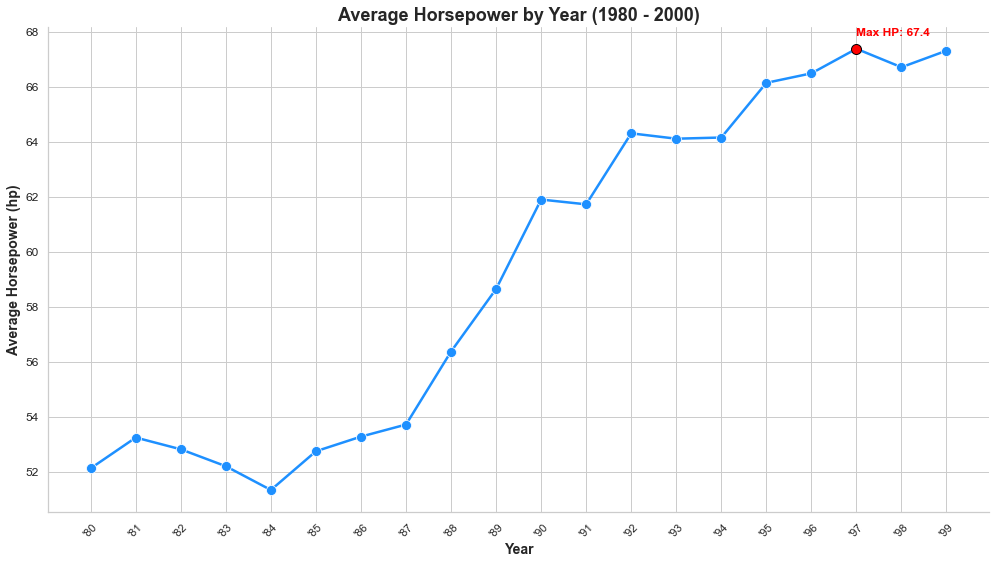

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'filtered_cars' is defined as shown previously
# avg_hp_per_year = filtered_cars.groupby('ye')['hp'].mean()  # This line would be used with your actual data

# Set Seaborn style for the plot
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(14, 8))
sns.lineplot(x=avg_hp_per_year.index, y=avg_hp_per_year, marker='o', color='dodgerblue', markersize=10, linewidth=2.5)

# Highlight the max value
max_hp = avg_hp_per_year.max()
max_year = avg_hp_per_year.idxmax()
plt.scatter(max_year, max_hp, color='red', s=100, edgecolor='black', zorder=5)
plt.text(max_year, max_hp + 0.5, f'Max HP: {max_hp:.1f}', fontsize=12, weight='bold', color='red')

# Improve the title and labels
plt.title('Average Horsepower by Year (1980 - 2000)', fontsize=18, fontweight='bold')
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Average Horsepower (hp)', fontsize=14, fontweight='bold')

# Customize the ticks for better readability
plt.xticks(avg_hp_per_year.index, labels=[f"'{str(year)[-2:]}" for year in avg_hp_per_year.index], rotation=45)
plt.yticks(fontsize=12)

# Remove Seaborn's default borders
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()



In [33]:
print(cars_IV[['Intercept', 'hp', 'ac', 'we', 'le', 'z']].describe())

       Intercept        hp        ac        we        le         z
count  9232.0000 9232.0000 9232.0000 9232.0000 9232.0000 9232.0000
mean      1.0000   58.3761   15.2414  996.3376  417.5121  417.5121
std       0.0000   24.1958    5.2325  225.0388   45.1930   45.1930
min       1.0000   17.0000    7.5000  530.0000  250.0000  250.0000
25%       1.0000   40.0000   12.0000  820.0000  384.0000  384.0000
50%       1.0000   55.0000   14.1000  970.0000  423.0000  423.0000
75%       1.0000   74.0000   17.0000 1170.0000  455.5000  455.5000
max       1.0000  169.5000   50.0000 1910.0000  506.0000  506.0000


## Prøver med Bertels kode fra øvelsestimerne??

- lave 2 gange OLS for at genskabe resultat så man ved hvad der foregår
- BLP estimates (z) - gennemsnit osv. - læse dokumentation
- Beregn elasticitet af formlerne 
- Negative priselasticiteter
- Sidste kolonne for nye instrumenter

# Priselasticiteter


In [34]:
def utility_function(price, alpha, x, beta):
    """
    Dette er et eksempel på en nyttefunktion, hvor:
    - price er prisen på produktet
    - alpha er koefficienten for prisen
    - x er en anden attribut for produktet
    - beta er koefficienten for attributten x
    """
    return alpha * price + beta * x

def calculate_price_elasticity(price, alpha, P_ni, x=None, beta=None):
    """
    Beregner priselasticiteten for en given pris og markedsandel (P_ni).
    """
    # V_ni som alpha * price => hvis kun pris påvirker nytten direkte
    V_ni_derivative = alpha  # FOC - Den afledte af V_ni med hensyn til pris er beta_price
    z_ni = price  # Prisen for produktet
    
    # Beregn elasticiteten - formlen
    elasticity = V_ni_derivative * z_ni * (1 - P_ni)
    
    return elasticity

# Antag at hver observation har samme vægt
num_observations = len(cars)
equal_weights = pd.Series([1] * num_observations)

# Beregn vægtede gennemsnitlige markedsandele
average_market_share = (cars['s'] * equal_weights).sum() / equal_weights.sum()
#average_market_share = cars['s'].mean()

# Beregn vægtede gennemsnitlige priser
average_price = (cars['princ'] * equal_weights).sum() / equal_weights.sum()
#average_price = cars['princ'].mean()

price = cars['princ']
P_ni = cars['s'] 

alpha = -1.0026 #Pris-koefficient fra OLS regressionen - må den være minus?
#-0.9308 

elasticity = calculate_price_elasticity(average_price, alpha, average_market_share)
#elasticity = (alpha * weighted_price * (1 - weighted_market_share)) / weighted_market_share


print(f"Priselasticiteten for markedet/produktet er: {elasticity}")


Priselasticiteten for markedet/produktet er: -0.6179679397871938


* Hver 1% ændring i prisen, vil mængden af efterspurgt ændre sig med ca. 0.776% i den modsatte retning
* Hvor følsom efterspørgslen efter et produkt eller en service er over for ændringer i prisen på dette produkt
* Relativt uelastiske, hvilket betyder, at efterspørgslen ikke er meget følsom over for prisændringer.

## Priselasticitet for hvert land

In [35]:
# Liste over lande
countries = ['Belgium', 'France', 'Germany', 'Italy', 'UK']

# Sørg for, at alle relevante kolonner er renset for NaN og uendelige værdier
cars[attributes] = cars[attributes].replace([np.inf, -np.inf], np.nan)
cars.dropna(subset=attributes, inplace=True)

# Dictionary til at holde elasticiteter for hvert land
elasticities = {}

# Beregn priselasticiteten for hvert land
for country in countries:
    # Filtrer datasættet for det aktuelle land
    country_data = cars[cars['country'] == country]

    # Tjek at der er data for det aktuelle land
    if not country_data.empty:
        # Beregn gennemsnitsværdier for pris og markedsandel
        average_price = country_data['princ'].mean()
        average_market_share = country_data['s'].mean()

        # Beregn priselasticitet for det aktuelle land
        elasticity = calculate_price_elasticity(average_price, alpha, average_market_share)
        elasticities[country] = elasticity
    else:
        print(f"Ingen data tilgængelige for {country}.")

# Udskriv priselasticiteter for hvert land
for country, elasticity in elasticities.items():
    print(f"Priselasticiteten for {country}: {elasticity:.4f}")


Priselasticiteten for Belgium: -0.7308
Priselasticiteten for France: -0.7450
Priselasticiteten for Germany: -0.6581
Priselasticiteten for Italy: -0.9621
Priselasticiteten for UK: -1.0441


## Priselasticitet for specifikt brand, år og land - Mangler

In [36]:
alpha = -1.0026

average_price = cars['princ'].mean()

price = cars['princ']
P_ni = cars['s'] 

specific_data = cars[(cars['brand_alfa romeo'] == 1) & (cars['ye'] == 83) & (cars['country'] == 'Belgien')]

# Tjek og print specifik data for at bekræfte
print("Specifik data for Alfa Romeo i Belgien, 1983:")
print(specific_data[['brand_alfa romeo', 'ye', 'country', 'princ']])

# Beregn gennemsnitsprisen for Alfa Romeo biler
# Her bruger vi 'brand_alfa romeo' == 1 som dummy,til at filtrere alle Alfa Romeo biler
average_price_alfa_romeo = cars[cars['brand_alfa romeo'] == 1]['princ'].mean()
#print(f"\nGennemsnitsprisen for Alfa Romeo biler er: {average_price_alfa_romeo:.2f}")

# Nu beregner vi priselasticiteten for Alfa Romeo biler
cars['price_elasticity_IV'] = alpha * cars['princ'] / (1 - cars['s']) #* (cars['brand_alfa romeo'] == 1)

#V_ni_derivative * z_ni * (1 - P_ni)


# Vis resultatet for Alfa Romeo biler
alfa_romeo_elasticity = cars[cars['brand_alfa romeo'] == 1]
print("\nPriselasticiteten for Alfa Romeo biler:")
print(alfa_romeo_elasticity[['brand_alfa romeo', 'ye', 'country', 'princ', 'price_elasticity_IV']])


Specifik data for Alfa Romeo i Belgien, 1983:
Empty DataFrame
Columns: [brand_alfa romeo, ye, country, princ]
Index: []

Priselasticiteten for Alfa Romeo biler:
       brand_alfa romeo  ye  country  princ  price_elasticity_IV
1                     1  84  Belgium 0.7620              -0.7683
2                     1  85  Belgium 0.7363              -0.7421
3                     1  86  Belgium 0.6591              -0.6647
4                     1  87  Belgium 0.6493              -0.6547
5                     1  88  Belgium 0.6525              -0.6576
...                 ...  ..      ...    ...                  ...
9308                  1  97       UK 1.1673              -1.1709
11254                 1  70       UK 1.3906              -1.3966
11506                 1  98       UK 1.2228              -1.2291
11507                 1  99       UK 1.1757              -1.1827
11531                 1  99       UK 1.5289              -1.5336

[259 rows x 5 columns]


In [37]:
print(cars.columns)

Index(['ye', 'ma', 'co', 'zcode', 'brd', 'type', 'model', 'org', 'loc', 'cla',
       'home', 'frm', 'qu', 'cy', 'hp', 'we', 'pl', 'do', 'le', 'wi', 'he',
       'li1', 'li2', 'li3', 'li', 'sp', 'ac', 'pr', 'princ', 'eurpr', 'exppr',
       'avexr', 'avdexr', 'avcpr', 'avppr', 'avdcpr', 'avdppr', 'xexr', 'tax',
       'pop', 'ngdp', 'rgdp', 'engdp', 'ergdp', 'engdpc', 'ergdpc', 'country',
       'qu_total', 's', 'log_s', 'class', 'hp_bin', 'market_share_bin',
       'brand_MCC', 'brand_VW', 'brand_alfa romeo', 'brand_audi',
       'brand_citroen', 'brand_daewoo', 'brand_daf', 'brand_daihatsu',
       'brand_fiat', 'brand_ford', 'brand_honda', 'brand_hyundai',
       'brand_innocenti', 'brand_kia', 'brand_lancia', 'brand_mazda',
       'brand_mercedes', 'brand_mitsubishi', 'brand_nissan', 'brand_opel',
       'brand_peugeot', 'brand_renault', 'brand_rover', 'brand_saab',
       'brand_seat', 'brand_simca', 'brand_skoda', 'brand_subaru',
       'brand_suzuki', 'brand_tal/hillman', 'brand

# Egenpriselasticitet

In [38]:
def calculate_own_price_elasticity(alpha, price, P_ni):
    """
    Beregner egenpriselasticiteten for et produkt.
    :param beta_price: Koefficienten for pris.
    :param price: Prisen på produktet.
    :param P_ni: Markedsandelen for produktet.
    :return: Egenpriselasticiteten.
    """
    own_price_elasticity = alpha * price * (1 - P_ni)
    return own_price_elasticity

# Præsenterer princ

alpha = -1.0026 #Pris-koefficient fra OLS regressionen - må den være minus?
#-0.9308

price = cars['princ'] # Prisen på produktet
P_ni = cars['s'] #P_ni = s = Markedsandelen for produktet

own_price_elasticity = calculate_own_price_elasticity(alpha, price, P_ni)

print(f"Egenpriselasticiteten er: {own_price_elasticity}")

Egenpriselasticiteten er: 1       -0.7597
2       -0.7344
3       -0.6570
4       -0.6473
5       -0.6508
          ...  
11544   -1.5009
11545   -1.1935
11546   -0.4869
11547   -0.5128
11548   -0.9404
Length: 9232, dtype: float64


* Efterspørgslen efter et bestemt produkt ændrer sig som følge af en ændring i prisen på netop dette produkt, mens alle andre faktorer holdes konstante
* Efterspørgslen ændrer sig for hvor meget man ændrer prisen => Alle valutaer ikke i 

In [39]:
# Filtrer data
alfa_33_belgium = cars[
    (cars['type'] == 'alfa 33') & 
    (cars['brand_alfa romeo'] == 1) & 
    (cars['country'] == 'Belgium') & 
    (cars['ye'] >= 80) &  # Assuming 'ye' contains the year as the last two digits
    (cars['ye'] <= 100)
]

# Tjek om der er nogen data efter filtrering
if not alfa_33_belgium.empty:
    # Beregn det totale af markedsandele for alle Alfa 33 biler i Belgien
    total_market_share = alfa_33_belgium['s'].sum()

    # Beregn det vægtede gennemsnit af priserne, hvor hver pris vægtes med sin respektive markedsandel
    alpha_alfa_33 = np.average(alfa_33_belgium['princ'], weights=alfa_33_belgium['s'])

    # Anvend den vægtede gennemsnitlige pris til at beregne elasticitet for hver bil
    alfa_33_belgium['own_price_elasticity'] = alfa_33_belgium.apply(
        lambda row: calculate_own_price_elasticity(alpha_alfa_33, row['princ'], row['s']), axis=1)

    # Beregn det vægtede gennemsnit af egenpriselasticiteten, hvor hver elasticitet vægtes med sin respektive markedsandel
    weighted_elasticity_sum = np.sum(alfa_33_belgium['own_price_elasticity'] * alfa_33_belgium['s'])
    average_own_price_elasticity = weighted_elasticity_sum / total_market_share if total_market_share != 0 else np.nan

    # Vis det vægtede gennemsnit af egenpriselasticiteten for Alfa 33 i Belgien
    print(f"Gennemsnitlig egenpriselasticitet for alfa 33 i Belgien: {average_own_price_elasticity:.4f}")
else:
    # Print en meddelelse hvis der ikke findes nogen data
    print("Ingen data tilgængelig for Alfa 33 i Belgien.")

Gennemsnitlig egenpriselasticitet for alfa 33 i Belgien: 0.4229


/var/folders/fq/jrmcw87s5bvdvtl2jq535p1m0000gn/T/ipykernel_94067/2428902365.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alfa_33_belgium['own_price_elasticity'] = alfa_33_belgium.apply(


* Kan ikke bare tage .mean, skal tage for * marketshare/marketshare.sum() => Beregnet?

## Beregning af Egenpriselasticiteten for Hvert Brand


In [40]:
alpha = -1.0026 

# Erstatning af 0 i markedsandelen med NaN for at undgå division med nul i beregningen
cars['own_price_elasticity'] = alpha * cars['princ'] / (1 - cars['s'].replace(0, np.nan))

# Liste af kolonner for forskellige brands
brand_columns = ['brand_MCC', 'brand_VW', 'brand_alfa romeo', 'brand_audi',
       'brand_citroen', 'brand_daewoo', 'brand_daf', 'brand_daihatsu',
       'brand_fiat', 'brand_ford', 'brand_honda', 'brand_hyundai',
       'brand_innocenti', 'brand_kia', 'brand_lancia', 'brand_mazda',
       'brand_mercedes', 'brand_mitsubishi', 'brand_nissan', 'brand_opel',
       'brand_peugeot', 'brand_renault', 'brand_rover', 'brand_saab',
       'brand_seat', 'brand_simca', 'brand_skoda', 'brand_subaru',
       'brand_suzuki', 'brand_tal/hillman', 'brand_tal/simca',
       'brand_tal/sunb', 'brand_talbot', 'brand_toyota', 'brand_volvo',
       'brand_yugo']  # Din liste af brands

# Dictionary til at holde gennemsnitlig priselasticitet og samlet markedsandel for hvert brand
brand_elasticity_data = {'Brand': [], 'Average Elasticity': [], 'Total Market Share': []}

# Beregning af gennemsnitlig priselasticitet for hvert brand
for brand_col in brand_columns:
    # Filtrér data for biler fra det specifikke brand
    brand_cars = cars[cars[brand_col] == 1]
    
    # Kontroller, at der er data for brandet
    if not brand_cars.empty:
        # Beregn den vægtede sum af elasticiteter for brandet
        weighted_sum = np.sum(brand_cars['own_price_elasticity'] * brand_cars['s'])
        # Beregn den samlede sum af markedsandele for brandet
        total_market_share = np.sum(brand_cars['s'])
        # Beregn det vægtede gennemsnit af elasticitet for brandet
        average_elasticity = weighted_sum / total_market_share if total_market_share != 0 else np.nan
    else:
        average_elasticity, total_market_share = np.nan, 0
    
    # Tilføj resultaterne til listen
    brand_elasticity_data['Brand'].append(brand_col.split('_')[1].title())  # Formaterer brand navnet
    brand_elasticity_data['Average Elasticity'].append(average_elasticity)
    brand_elasticity_data['Total Market Share'].append(total_market_share)

# Opret en DataFrame fra dictionary
brand_elasticity_df = pd.DataFrame(brand_elasticity_data)

# Sorter DataFrame baseret på 'Average Elasticity' eller 'Total Market Share'
brand_elasticity_df = brand_elasticity_df.sort_values('Average Elasticity', ascending=False)

# Vis DataFrame
brand_elasticity_df

,Brand,Average Elasticity,Total Market Share
0,Mcc,-0.3802,0.0218
28,Suzuki,-0.3953,0.1120
27,Subaru,-0.4011,0.0067
35,Yugo,-0.4296,0.0490
26,Skoda,-0.4363,0.2443
7,Daihatsu,-0.4483,0.1028
13,Kia,-0.4685,0.0516
24,Seat,-0.4937,1.1138
11,Hyundai,-0.5410,0.2200
6,Daf,-0.5516,0.2958


In [41]:
cars['s'].sum()

129.12801089377265

Kan være fejl ved definition af 'own_price_elasticity'

* Tager ikke højde for marketshare og priselasticitet - lave et vægtet gennemsnit => Beregnet?
Gange bars (elasticitet) med marketshare og dividere med summen af marketshares: Vægtet gennemsnit => Beregnet?

In [42]:
import matplotlib.pyplot as plt

# Forudsætter, at 'brands' er en liste af brand-navne og 'elasticities' er de tilsvarende priselasticitetsværdier.
brands = list(brand_elasticities.keys())  # Brand-navne
elasticities = list(brand_elasticities.values())  # Priselasticitetsværdier

# For at skabe et linjediagram, skal du først sørge for, at dataene er sorteret i den rækkefølge, du vil visualisere dem.
# Her antages det, at 'brands' allerede er i den ønskede rækkefølge. Hvis ikke, skal du sortere dem først.

plt.figure(figsize=(13, 8))
plt.plot(brands, elasticities, marker='o', linestyle='-', color='blue')  # Tilføjer markører til punkterne
plt.xticks(rotation=45)  # Roterer mærkerne på x-aksen for bedre læsbarhed
plt.xlabel('Brand')
plt.ylabel('Gennemsnitlig Priselasticitet')
plt.title('Gennemsnitlig Priselasticitet for Brands')
plt.grid(True)  # Tilføjer et gitter for bedre læsbarhed

# Viser plot
plt.tight_layout()  # Justerer layout for at sikre, at alt passer ind
plt.show()


NameError: name 'brand_elasticities' is not defined

## Krydspriselasticitet

### Alle brands i alle lande

In [ ]:
def calculate_cross_price_elasticity(p_ik, x_ik, beta):
    """
    Beregner krydspriselasticiteten.
    :param p_ik: Markedsandelen for produkt k.
    :param x_ik: Prisen på produkt k.
    :param beta: Den relevante prisparameter.
    :return: Krydspriselasticiteten.
    """
    cross_price_elasticity = -p_ik * x_ik * beta
    return cross_price_elasticity

beta_z = -0.9308

# Initialize results list
results = []

# Get unique countries from the dataset
countries = cars['country'].unique()

# Loop through each country
for country in countries:
    # Filter the data for the current country
    country_data = cars[cars['country'] == country]
    
    # Get the unique brands within this country
    brand_columns = [col for col in country_data.columns if 'brand_' in col]
    brands = [col.split('_')[1] for col in brand_columns]

    # Calculate cross-price elasticity for each pair of brands within the country
    for i in range(len(brands)):
        for j in range(i + 1, len(brands)):
            brand_i = brands[i]
            brand_j = brands[j]
            cars_brand_i = country_data[(country_data[f'brand_{brand_i}'] == 1)]
            cars_brand_j = country_data[(country_data[f'brand_{brand_j}'] == 1)]

            if not cars_brand_i.empty and not cars_brand_j.empty:
                x_ik = cars_brand_i['princ'].mean()
                p_ik = cars_brand_j['s'].mean()

                if pd.notna(x_ik) and pd.notna(p_ik) and p_ik != 0 and x_ik != 0:
                    elasticity = calculate_cross_price_elasticity(p_ik, x_ik, beta_z)
                    results.append((country, brand_i, brand_j, elasticity))
                else:
                    results.append((country, brand_i, brand_j, 'Invalid or missing data for calculation'))
            else:
                results.append((country, brand_i, brand_j, 'No data for one or both brands'))

# Output results
for result in results:
    print(f"In {result[0]}, the cross-price elasticity between {result[1]} and {result[2]} is: {result[3]}")


### Gennnemsnit af krydspriselasticitet for de 5 lande

In [ ]:
def calculate_weighted_average(df, value_column, weight_column):
    """ Calculate a weighted average of a given value column, weighted by another column. """
    df = df[df[weight_column] > 0.0001]  # Anvend en tærskel for at udelukke meget små markedsandele
    weighted_sum = (df[value_column] * df[weight_column]).sum()
    total_weight = df[weight_column].sum()
    return weighted_sum / total_weight if total_weight != 0 else 0

country = 'Belgium'


# ['Belgium', 'France', 'Germany', 'Italy', 'UK']

# Filtrer data for kun at inkludere data fra Belgien
belgium_data = cars[cars['country'] == country]

# Identificer alle brands
brand_columns = [col for col in belgium_data.columns if 'brand_' in col]
brands = [col.split('_')[1] for col in brand_columns]

elasticity_values = []

for i in range(len(brands)):
    for j in range(i + 1, len(brands)):
        brand_i = brands[i]
        brand_j = brands[j]
        cars_brand_i = belgium_data[(belgium_data[f'brand_{brand_i}'] == 1)]
        cars_brand_j = belgium_data[(belgium_data[f'brand_{brand_j}'] == 1)]

        weighted_price_i = calculate_weighted_average(cars_brand_i, 'princ', 's')
        weighted_price_j = calculate_weighted_average(cars_brand_j, 'princ', 's')
        weighted_market_share_i = calculate_weighted_average(cars_brand_i, 's', 's')
        weighted_market_share_j = calculate_weighted_average(cars_brand_j, 's', 's')

        if weighted_market_share_i > 0 and weighted_market_share_j > 0:
            elasticity_i_j = calculate_cross_price_elasticity(weighted_market_share_j, weighted_price_i, beta_z)
            elasticity_j_i = calculate_cross_price_elasticity(weighted_market_share_i, weighted_price_j, beta_z)
            elasticity_values.append(elasticity_i_j)
            elasticity_values.append(elasticity_j_i)

average_elasticity = sum(elasticity_values) / len(elasticity_values) if elasticity_values else 0
print(f"The average cross-price elasticity for all brand pairs in Belgium is: {average_elasticity:.4f}")


In [ ]:
# Eksempel på at kontrollere statistikker for 'princ' og 's'
print(belgium_data['princ'].describe())
print(belgium_data['s'].describe())

# Tjek for nul-værdier eller meget små værdier, der kan påvirke vægtningen
print(belgium_data[belgium_data['s'] <= 0.001])  # Eksempel på at finde meget små markedsandele


### Top 5 most expenisve brands in Italy

In [ ]:
def get_top_expensive_brands(cars, country, n=5):
    """
    Identify the top n most expensive brands based on average price in a specified country.
    """
    brand_columns = [col for col in cars.columns if 'brand_' in col]
    average_prices = {}
    for brand_col in brand_columns:
        brand_name = brand_col.split('_')[1]  # Assuming column names like 'brand_audi'
        brand_data = cars[(cars[brand_col] == 1) & (cars['country'] == country)]
        average_price = brand_data['princ'].mean()
        if pd.notna(average_price):  # Only include brands with calculable average prices
            average_prices[brand_name] = average_price
    
    # Sort brands by average price in descending order and pick top n
    sorted_brands = sorted(average_prices, key=average_prices.get, reverse=True)[:n]
    return sorted_brands

In [ ]:
top_expensive_brands = get_top_expensive_brands(cars, 'Italy', 5)
results = perform_elasticity_analysis(cars, 'Italy', top_expensive_brands)

# Print results
for result in results:
    print(f"The cross-price elasticity between {result[0]} and {result[1]} in Italy is: {result[2]}")

In [ ]:
belgian_brands = get_all_brands(cars, 'Belgium')
elasticity_results = perform_elasticity_analysis(cars, 'Belgium', belgian_brands)

# Create a DataFrame from the results
elasticity_df = pd.DataFrame.from_dict(elasticity_results, orient='index', columns=['Elasticity'])
elasticity_df.index = pd.MultiIndex.from_tuples(elasticity_df.index)
elasticity_df = elasticity_df.unstack().fillna(0)

# Trin 2: Visualiser resultaterne
plt.figure(figsize=(12, 10))
sns.heatmap(elasticity_df['Elasticity'], annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Cross-Price Elasticity Matrix for Car Brands in Belgium')
plt.xlabel('Brand J')
plt.ylabel('Brand I')
plt.show()

* Gøre det for alle. Derefter for et bestemt marked med et bestemt... aggregeret
* Måske 5 mest solgte brands så der ikke er for mange tal

### Spørgsmål til Bertel

- Sammenligne med en hvor prisen er med
- tage OLS hvor log_s på venstre side
- 2SLS ukorrileret med exogene variable - ikke med prisen
- Prisen er korrileret med et instrument som er ukorrileret med fejlledet
- Godt at sammenligne OLS med IV
- Sammenligne med efterspørgselsligning (log_s mod attributes og prices med OLS)
- Se hvordan priskoefficienten ændrer sig 
- Lave en tabel med OLS, IV - kontrollere for fixed effects, forskellen på IV og OLS - Samle det hele i bunden
- Hvad er egenpris og kryds som ekstra række - 

- **Tilføje gennemsnitlige, vægtede gennemsnit for hele markedet**

In [43]:
# Create a DataFrame for the OLS results
firststage_results = pd.DataFrame({
    'Coefficient': first_stage.params,
    'Std. Error': first_stage.bse,
    't-value': first_stage.tvalues,
    'p-value': first_stage.pvalues
})

# Create a DataFrame for the IV results
secondstage_results = pd.DataFrame({
    'Coefficient': second_stage.params,
    'Std. Error': second_stage.std_errors,
    #'t-value': second_stage.tvalues, #- Ingen t-værdi for IV eller hvorfor fejl?
    'p-value': second_stage.pvalues
})

# AC:

# Create a DataFrame for the OLS results
firststage_results_ac = pd.DataFrame({
    'Coefficient': first_stage_ac.params,
    'Std. Error': first_stage_ac.bse,
    't-value': first_stage_ac.tvalues,
    'p-value': first_stage_ac.pvalues
})

# Create a DataFrame for the IV results
secondstage_results_ac = pd.DataFrame({
    'Coefficient': second_stage_ac.params,
    'Std. Error': second_stage_ac.std_errors,
    #'t-value': second_stage.tvalues, #- Ingen t-værdi for IV eller hvorfor fejl?
    'p-value': second_stage_ac.pvalues
})


#WE:


# Create a DataFrame for the OLS results
firststage_results_we = pd.DataFrame({
    'Coefficient': first_stage_we.params,
    'Std. Error': first_stage_we.bse,
    't-value': first_stage_we.tvalues,
    'p-value': first_stage_we.pvalues
})

# Create a DataFrame for the IV results
secondstage_results_we = pd.DataFrame({
    'Coefficient': second_stage_we.params,
    'Std. Error': second_stage_we.std_errors,
    #'t-value': second_stage.tvalues, #- Ingen t-værdi for IV eller hvorfor fejl?
    'p-value': second_stage_we.pvalues
})


#LE:

# Create a DataFrame for the OLS results
firststage_results_le = pd.DataFrame({
    'Coefficient': first_stage_le.params,
    'Std. Error': first_stage_le.bse,
    't-value': first_stage_le.tvalues,
    'p-value': first_stage_le.pvalues
})

# Create a DataFrame for the IV results
secondstage_results_le = pd.DataFrame({
    'Coefficient': second_stage_le.params,
    'Std. Error': second_stage_le.std_errors,
    #'t-value': second_stage.tvalues, Ingen t-værdi for IV
    'p-value': second_stage_le.pvalues
})



# OLS-regressionsmodel har kørt med 'princ' og andre attributter
ols_results_with_princ = pd.DataFrame({
    'Coefficient': model.params,
    'Std. Error': model.bse,
    't-value': model.tvalues,
    'p-value': model.pvalues
})#.reset_index().rename(columns={'index': 'Variable'})

NameError: name 'first_stage_ac' is not defined

In [44]:
# Combine the results into one DataFrame for comparison
comparison_table = pd.DataFrame({
    'OLS Coefficient': firststage_results['Coefficient'],
    'IV Coefficient': secondstage_results['Coefficient'],
    'OLS Coefficient_ac': firststage_results_ac['Coefficient'],
    'IV Coefficient_ac': secondstage_results_ac['Coefficient'],
    'OLS Coefficient_we': firststage_results_we['Coefficient'],
    'IV Coefficient_we': secondstage_results_we['Coefficient'],
    'OLS Coefficient_le': firststage_results_le['Coefficient'],
    'IV Coefficient_le': secondstage_results_le['Coefficient'],
    
    'OLS Std. Error': firststage_results['Std. Error'],
    'IV Std. Error': secondstage_results['Std. Error'],
    'OLS Std. Error_ac': firststage_results_ac['Std. Error'],
    'IV Std. Error_ac': secondstage_results_ac['Std. Error'],
    'OLS Std. Error_we': firststage_results_we['Std. Error'],
    'IV Std. Error_we': secondstage_results_we['Std. Error'],
    'OLS Std. Error_le': firststage_results_le['Std. Error'],
    'IV Std. Error_le': secondstage_results_le['Std. Error'],
    
    'OLS p-value': firststage_results['p-value'],
    'IV p-value': secondstage_results['p-value'],
    'OLS p-value_ac': firststage_results_ac['p-value'],
    'IV p-value_ac': secondstage_results_ac['p-value'],
    'OLS p-value_we': firststage_results_we['p-value'],
    'IV p-value_we': secondstage_results_we['p-value'],
    'OLS p-value_le': firststage_results_le['p-value'],
    'IV p-value_le': secondstage_results_le['p-value'],

})

# Givne beregnede værdier for priselasticitet og egenpriselasticitet
price_elasticity_value = -0.7759 
own_price_elasticity_value = -0.7093          

# Tilføj priselasticitet og egenpriselasticitet 
# Vi bruger `np.nan` til at udfylde kolonner, hvor vi ikke har værdier
comparison_table.loc['Price Elasticity'] = [price_elasticity_value] + [np.nan] * (len(comparison_table.columns) - 1)
comparison_table.loc['Own Price Elasticity'] = [own_price_elasticity_value] + [np.nan] * (len(comparison_table.columns) - 1)


comparison_table



NameError: name 'firststage_results_ac' is not defined

p-værdi: signifikant effekt på den afhængige variabel i modellen (under 0.05)
* Priselasticiteten for hver estimation => det kan sammenlignes => foreksllige alpha
* Vise gennemsnitlige krydspriselasticitet, vægtet med marketshare
* Første, vise priselasticitet med endogenitetsproblem => oven, alpha beta (hp, priscoeffiecent ...) => OLS, pirce ik price fitted
* 2, Old price elasticity, r-squared, statistics fra tabellen. Flere specifikationer af samme model. IV forskellige instrumenter og vise hvordan prisen har ændret sig
* Fixed effects, hvordan modellen ændrer sig 
* IV med forskellige instrumenter => Kun vise for second stage
* 2 tabeller => 1 med first stage regression (marketshare for y), 1 med OLS, fixed effects og 2nd stage IV


- Hvilket brands tages der fat i her?
- Skal med ind i tabellen
- Ols, OLS med brand, OLS med ..., IV 1,2,3 (forskellige valg af instrumenter), priscoefficent hele vejen hen, product på y - Kan ikke sammenligne koeffiecienter
- Beta/sigma går ikke, hvad så? - Binary probit => 
- y* = xbeta + epsilon, N(0, siga^2) y = 1/y* (y*>0), P(y=1|x) = fordelingsfunktionen(xbeta/sigma))
- dif P(y=y|lambda) dif sigma x_k = ø(xbeta / sigma) beta_k/sigma => skal vide beta og sigma i forhold til hinanden ikke hver for sig
- /p og /x= normalisere => kun kende beta/sigma
- nederste rækker = Elasticity_own og Elasticity_cross på tværst af estimaterne til at finde, den med negativ tegn (nedadgående demand)
- Argumentere for hvorfor den er endogen
- Kontrollere for omitted variable
- Forskellige markeder/tider osv.
- kolonne for instrumenterne også argumentere for dem - Herfra vælge den bedste - 
- Variation for at finde bedste price respons - kan også bruge det her instruemnt (Ghandi mm.)
- Kommer til sidst til en konklussion: tager et tal
- Kontrafaktiske beregninger for 5 forskellige beregniner, ændre marginale omkostninger ved benzin biler osv.


**Spørgsmål til Bertel**:
- Hvordan opitmerer jeg krydspriselasticiteten?
- Egenpriser for alle brands er meget ekstrem, hvad kan gøres ved dataen?
- Jeg er ret sikker på mit instrument 'z', men hvad med de andre?
- Får ikke de samme egenpriselasticiteter for et brand, som i Verboven paper
    - Der er nok noget galt med DataFrame ift. måden jeg definerer brands
- Hvorfor giver cars['s'].sum() ikke 1?
    
**Spørgsmål til CounterFactual calculations**
- 1) Annual fuel price (evt. i dollars hvis valuta er nødvendig) 
- 2) Baseline Predictions (Numerical Stability)
    - Regne sum for hvert marked og år
- 3) Tænkte om vi skulle kige på beskattelse i stedet for indtrædelse af ny bil på markedet? Her kunne jeg komme ind på Feebate?
    - Evt. komme ind på Feebate (tilbagebetaling for miljøvenlige biler, afgift på miljøskadelige)
        - Påvirker købernes købsvane så de vælger en grønnere bil?
    - Herefter regne den nye pris for biler med Fee-Bate
    - Regne Market Share for FeeBate
- 4) Komme ind på hvad skatten på tankning skal være?
- 5) Counterfactual simulation 
    - Sammenligne priserne før og efter beskatningerne
    - Regne alle salg med nyt market share 
    - CO2 emission
        - Graf for denne emission
    - **Opfølgende spørgsmål:**
        - Nogen grund til at bruge exchange rate?
        

Flere spørgsmål:
- Hvorfor er min cars['s'].sum() dette tal?
- Ikke samme attributes som i paper - gør det noget